# Yeast cells detection evaluation notebook

Evaluates the performance of segmentation and tracking on the YIT ground truth data set. 

Performances are displayed as calibration curves over the `segmentation_threshold`, and as a calibration heatmap over the tracking hyperparameters `dmax` and `epsilon`.

In [1]:
try:
  from yeastcells import data, yit, segmentation, tracking, evaluation
except ImportError:
  # Outside of colab, it is necesary to manually install scikit-learn, seaborn, torch and torchvision, e.g.:
  # !pip3 install scikit-learn torch torchvision seaborn
  !pip3 install -U pyyaml # resolves: FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.7/dist-packages/PyYAML-3.13.dist-info/METADATA
  !pip3 install -U git+https://github.com/ymzayek/yeastcells-detection-maskrcnn.git
  from yeastcells import data, yit, segmentation, tracking, evaluation

exports_for_paper = True

     |████████████████████████████████| 645kB 18.0MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/ymzayek/yeastcells-detection-maskrcnn.git to /tmp/pip-req-build-6l4gva_k
  Running command git clone -q https://github.com/ymzayek/yeastcells-detection-maskrcnn.git /tmp/pip-req-build-6l4gva_k
     |████████████████████████████████| 29.2MB 105kB/s 
     |████████████████████████████████| 6.8MB 48.5MB/s 
     |████████████████████████████████| 50.4MB 57kB/s 
     |████████████████████████████████| 56.4MB 56kB/s 
     |████████████████████████████████| 27.4MB 112kB/s 
     |████████████████████████████████| 952kB 56.0MB/s 
  Created wheel for yeastcells: filename=yeastcells-0.1.0-cp37-none-any.whl size=22332 sha256=e09eafb871d2d28be8fc4ff9cb7e9d81cbe74c8daa8dbda17311701ac29dd230
  Stored in directory: /tmp/pip-ephem-wheel-cache-146qyfw_/wheels/f4/52/88/844445e0458f07e35d33f0e51bec54975c55aa

In [2]:
import os
import time
import warnings
import tempfile
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from download import download
from skimage.io import imread, imsave
from itertools import product
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.sparse import coo_matrix
from sklearn.exceptions import EfficiencyWarning

%matplotlib inline

In [3]:
# Tested thresholds
thresholds = np.arange(.7, 0.99, 0.0025)

# Tested hyperparameter values for tracking
dmaxs = np.arange(2, 7, 1)
epsilons = np.arange(0.35, 0.91, 0.05)

testset_names = [
 'TestSet1', 'TestSet2', 'TestSet3', 'TestSet4',
 'TestSet5', 'TestSet6', 'TestSet7',
#  'TestSet8', 'TestSet9', 'TestSet10'
]

# Selected thresholds per test set
optimal_thresholds = {
    'TestSet1': 0.9775, 'TestSet2': 0.975, 'TestSet3': 0.8, 'TestSet4': 0.8,
    'TestSet5': 0.8, 'TestSet6': 0.8, 'TestSet7': 0.8}

## Download model and data

In [4]:
pipeline_path = f'./yeastcells-detection-maskrcnn'
model_filename = f'{pipeline_path}/model_final.pth'

download(
    'https://datascience.web.rug.nl/models/yeast-cells/mask-rcnn/v1/model_final.pth', model_filename)

download(
    'https://datascience.web.rug.nl/YeaZ_results.zip',
    f'{pipeline_path}/YeaZ_results/YeaZ_results.zip')

download(
    'https://datascience.web.rug.nl/YIT-Benchmark2.zip', 
    f'{pipeline_path}/YIT-Benchmark2/YIT-Benchmark2.zip')

!cd '{pipeline_path}' && unzip -o -qq 'YIT-Benchmark2/YIT-Benchmark2.zip' -d YIT-Benchmark2
!cd '{pipeline_path}' && unzip -o -qq 'YeaZ_results/YeaZ_results.zip' -d YeaZ_results

# We've precomputed the outcomes of the YeaZ model on the YIT data
def load_test_yeaz_detections(path, testset_name = 'TestSet1'):
  # one mask per frame, with integer encoded segmentation.
  masks = data.read_tiff_mask(f'{path}/YeaZ_results/YeaZ_masks_{testset_name}.tiff')

  # a dataframe with every detection per frame seperately
  yeaz_detections = pd.DataFrame([
    {'frame': frame, 'cell': cell}
    for frame, mask in enumerate(masks)
    for cell in np.unique(mask)
    if cell > 0
  ])

  # create one-hot encoded masks, like we get from the Mask-RCNN, such that they
  # fit our evaluation pipeline.
  masks = (
      masks[yeaz_detections['frame']] # repeat frames per detection of a frame
      == yeaz_detections['cell'].values[:, None, None] # one-hot encode
  )
  # we could use the dataframe's index, but a seperate column is safer to mutations
  yeaz_detections['mask'] = np.arange(len(masks))
  return masks, yeaz_detections


file_sizes: 100%|████████████████████████████| 351M/351M [00:10<00:00, 33.4MB/s]
Successfully downloaded file to ./yeastcells-detection-maskrcnn/model_final.pth

file_sizes: 100%|██████████████████████████| 1.21M/1.21M [00:00<00:00, 2.84MB/s]
Successfully downloaded file to ./yeastcells-detection-maskrcnn/YeaZ_results/YeaZ_results.zip

file_sizes: 100%|████████████████████████████| 263M/263M [00:08<00:00, 32.6MB/s]
Successfully downloaded file to ./yeastcells-detection-maskrcnn/YIT-Benchmark2/YIT-Benchmark2.zip


## Performance

### YeaZ vs. our Mask R-CNN pipeline

Comparing YeaZ and our model w.r.t. different metrics. We've used different thresholds per test set, as shown in the section 'Segmentation theshold optimization'. We've also determined general values for dmax and epsilon below.

In [5]:
metrics = []
import time

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(pipeline_path, testset_name)
  
  ground_truth = yit.get_ground_truth(pipeline_path, testset_name)
  
  # YeaZ results
  yeaz_masks, yeaz_detections = load_test_yeaz_detections(pipeline_path, testset_name)
  
  # Mask R-CNN results
  threshold = optimal_thresholds[testset_name]
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=threshold, device='cuda:0')
  
  # Tracking Mask R-CNN results via DBSCAN clustering
  maskrcnn_detections = tracking.track_cells(maskrcnn_detections, maskrcnn_masks,
                                             dmax=2, min_samples=3, eps=0.6, device='cuda:0')
  
  metrics.extend([
      {'test set': testset_name, 'task': task, 'model': model,
       'metric': metric, 'value': value}
      for task, get_metrics in {
          'tracking': evaluation.get_tracking_metrics,
          'segmentation': evaluation.get_segmention_metrics}.items()
      for model, detections, masks in [
        ('YeaZ', yeaz_detections, yeaz_masks),
        ('Mask R-CNN', maskrcnn_detections, maskrcnn_masks),
      ]
      for metric, value in evaluation.calculate_metrics(get_metrics(
        ground_truth, detections, masks)).items()
  ])

results = pd.DataFrame(metrics)

#### Results

In [6]:
resuts_table = results.sort_values(['metric', 'task', 'model']).pivot(
    ('test set', ), columns=('metric', 'task', 'model'), values='value')
resuts_table

metric       Accuracy                       ...       Recall                     
task     segmentation             tracking  ... segmentation   tracking          
model      Mask R-CNN      YeaZ Mask R-CNN  ...         YeaZ Mask R-CNN      YeaZ
test set                                    ...                                  
TestSet1     0.874150  0.646002   0.874451  ...     0.956261   0.874451  0.952590
TestSet2     0.925676  0.466443   0.935252  ...     0.958621   0.935252  0.949640
TestSet3     0.870578  0.857882   0.821281  ...     0.943933   0.829302  0.918605
TestSet4     0.828271  0.836032   0.741257  ...     0.879137   0.745603  0.834310
TestSet5     0.853147  0.779333   0.829019  ...     0.846378   0.838732  0.812543
TestSet6     0.871111  0.882609   0.839695  ...     0.918552   0.839695  0.895674
TestSet7     0.856242  0.927757   0.799710  ...     0.950032   0.813885  0.931315

[7 rows x 16 columns]

#### Export

In [7]:
results.pivot(('test set', 'model'),
              columns=('task', 'metric'),
              values='value').to_excel('maskrcnn-vs-yeaz.xlsx')

try:
  from google.colab.files import download
  download('maskrcnn-vs-yeaz.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Export for paper

In [8]:
# performance table of paper, essentially same as above.
if exports_for_paper:
  !pip3 install ipy_table
  from ipy_table import make_table, set_row_style, set_column_style, set_cell_style
  from IPython.display import HTML, display
  metrics = [['Accuracy', 'F1-score'], ['Precision', 'Recall']]

  headers = []
  rows = []
  for metric_row in metrics:
    header = []
    for metric in metric_row:
      header += [[metric, '', '']] + [list(c) for c in resuts_table[[metric]].columns]
    header = np.array(header)
    header[1:][header[1:] == header[:-1]] = ''
    header = [list(x) for x in header.T]
    headers.append([['&nbsp;'] * len(header[0])] + header[:1] if len(headers) > 0 else header)
    rows.append([
      sum([
        ['TS' + testset_name[-1:]] + list(row[metric])
        for metric in metric_row
      ], [])
      for testset_name, row in resuts_table.iterrows()
    ])
  table = make_table(sum([header+row for header, row in zip(headers, rows)], []))

  for i, row in enumerate(table.array):
    for j in [1, 3, 6, 8]:
      if isinstance(row[j], float) and isinstance(row[j+1], float):
        j += row[j+1] > row[j]
        set_cell_style(i, j, color='#eee')

  for row in [0, 1, 2, 10]:
    set_row_style(row, bold=True)
  for row in range(19):
    no_border = []
    if row not in [3, 10, 12]:
      no_border.append('top')
    if row not in [2, 9, 10, 18]:
      no_border.append('bottom')
    if len(no_border) > 0:
      set_row_style(row, no_border=','.join(no_border))
  for column in range(10):
    no_border = []
    set_column_style(column, width=90)
    if column != 5: no_border.append('left')
    if column != 6: no_border.append('right')
    set_column_style(column, no_border=','.join(no_border))
  set_column_style(0, bold=True); set_column_style(5, bold=True)

  set_column_style(5, thick_border='left')
  set_row_style(2, thick_border='bottom')
  set_row_style(9, thick_border='bottom')
  set_row_style(11, thick_border='bottom')
  set_row_style(18, thick_border='bottom')

  html = table._repr_html_().replace(
      '<table border="1" cellpadding="3" cellspacing="0" '
      ' style="border:black; border-collapse:collapse;">',
      '<table border="1" cellpadding="3" cellspacing="0" '
      ' style="border:black; border-collapse:collapse; font-family: serif;">')
  with open('performance-yeaz-vs-maskrcnn.html', 'w') as f:
    f.write(html)
  

  results.sort_values(['metric', 'task', 'model']).pivot(('test set'),
              columns=('metric', 'task', 'model'),
              values='value').to_excel('performance-yeaz-vs-maskrcnn.xlsx')
  !zip -qq paper-results.zip 'performance-yeaz-vs-maskrcnn.xlsx'
  !zip -qq paper-results.zip 'performance-yeaz-vs-maskrcnn.html'
  !rm 'performance-yeaz-vs-maskrcnn.html' 'performance-yeaz-vs-maskrcnn.xlsx'
  display(HTML(html))

  Created wheel for ipy-table: filename=ipy_table-1.15.1-cp37-none-any.whl size=18763 sha256=b9c504387f0b695a98ff613c9465ba85353418ebdf9c25ecf9f82668f9d1729d
  Stored in directory: /root/.cache/pip/wheels/03/89/01/203b61b7dbeb396ead2459258138e92d9cc1b8a1cc90bf570d
Successfully built ipy-table


Accuracy,,,,,F1-score,,,,
,segmentation,,tracking,,,segmentation,,tracking,
,Mask R-CNN,YeaZ,Mask R-CNN,YeaZ,,Mask R-CNN,YeaZ,Mask R-CNN,YeaZ
TS1,0.8741,0.6460,0.8745,0.6576,TS1,0.9328,0.7849,0.9330,0.7934
TS2,0.9257,0.4664,0.9353,0.4907,TS2,0.9614,0.6362,0.9665,0.6584
TS3,0.8706,0.8579,0.8213,0.8205,TS3,0.9308,0.9235,0.9019,0.9014
TS4,0.8283,0.8360,0.7413,0.7628,TS4,0.9061,0.9107,0.8514,0.8654
TS5,0.8531,0.7793,0.8290,0.7233,TS5,0.9208,0.8760,0.9065,0.8394
TS6,0.8711,0.8826,0.8397,0.8441,TS6,0.9311,0.9376,0.9129,0.9155
TS7,0.8562,0.9278,0.7997,0.8931,TS7,0.9226,0.9625,0.8887,0.9435
,,,,,,,,,


### Segmentation theshold optimization

In [9]:
metrics = []

# It's fair to assume the tracking performance depends on the segmentation
# performance, rather then also the segmentation hyper parameters, and to hence
# optimize this threshold orthogonally from the tracking ones
measure_tracking = False

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(pipeline_path, testset_name)
  ground_truth = yit.get_ground_truth(pipeline_path, testset_name)
  
  # Mask R-CNN results
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=float(thresholds.min()),
      device='cuda:0')
  
  for i, threshold in enumerate(tqdm(thresholds,
                                     desc=f'Progress for {testset_name}',
                                     leave=False)):
    # Filter out detections according to threshold
    above_threshold = maskrcnn_detections['segmentation_score'] >= threshold
    maskrcnn_detections_above_threshold = maskrcnn_detections[above_threshold].copy()
    
    if above_threshold.sum() == 0:
      metrics.extend([
        {'test set': testset_name, 'task': task, 'metric': metric,
         'value': 0, 'threshold': threshold, 'model': 'Mask R-CNN'}
         for task in ['segmentation', 'tracking'][:1+int(measure_tracking)]
         for metric in ['F1-score', 'Accuracy', 'Recall', 'Precision']
      ])
      continue
    
    if measure_tracking:
      # Tracking Mask R-CNN results via DBSCAN clustering
      maskrcnn_detections_above_threshold = tracking.track_cells(
        maskrcnn_detections_above_threshold, maskrcnn_masks,
        dmax=2, min_samples=3, eps=0.6, device='cuda:0')
  
    metrics.extend([
        {'test set': testset_name, 'task': task, 'metric': metric,
         'value': value, 'threshold': threshold, 'model': 'Mask R-CNN'}
        for task, get_metrics in {
            'tracking': evaluation.get_tracking_metrics,
            'segmentation': evaluation.get_segmention_metrics}.items()
        if task in ['segmentation', 'tracking'][:1+int(measure_tracking)]
        for metric, value in evaluation.calculate_metrics(get_metrics(
          ground_truth, maskrcnn_detections_above_threshold, maskrcnn_masks
        )).items()
    ])

threshold_results = pd.DataFrame(metrics)

#### Results

The performance of segmentation and tracking shown as calibration curves with respect to the threshold

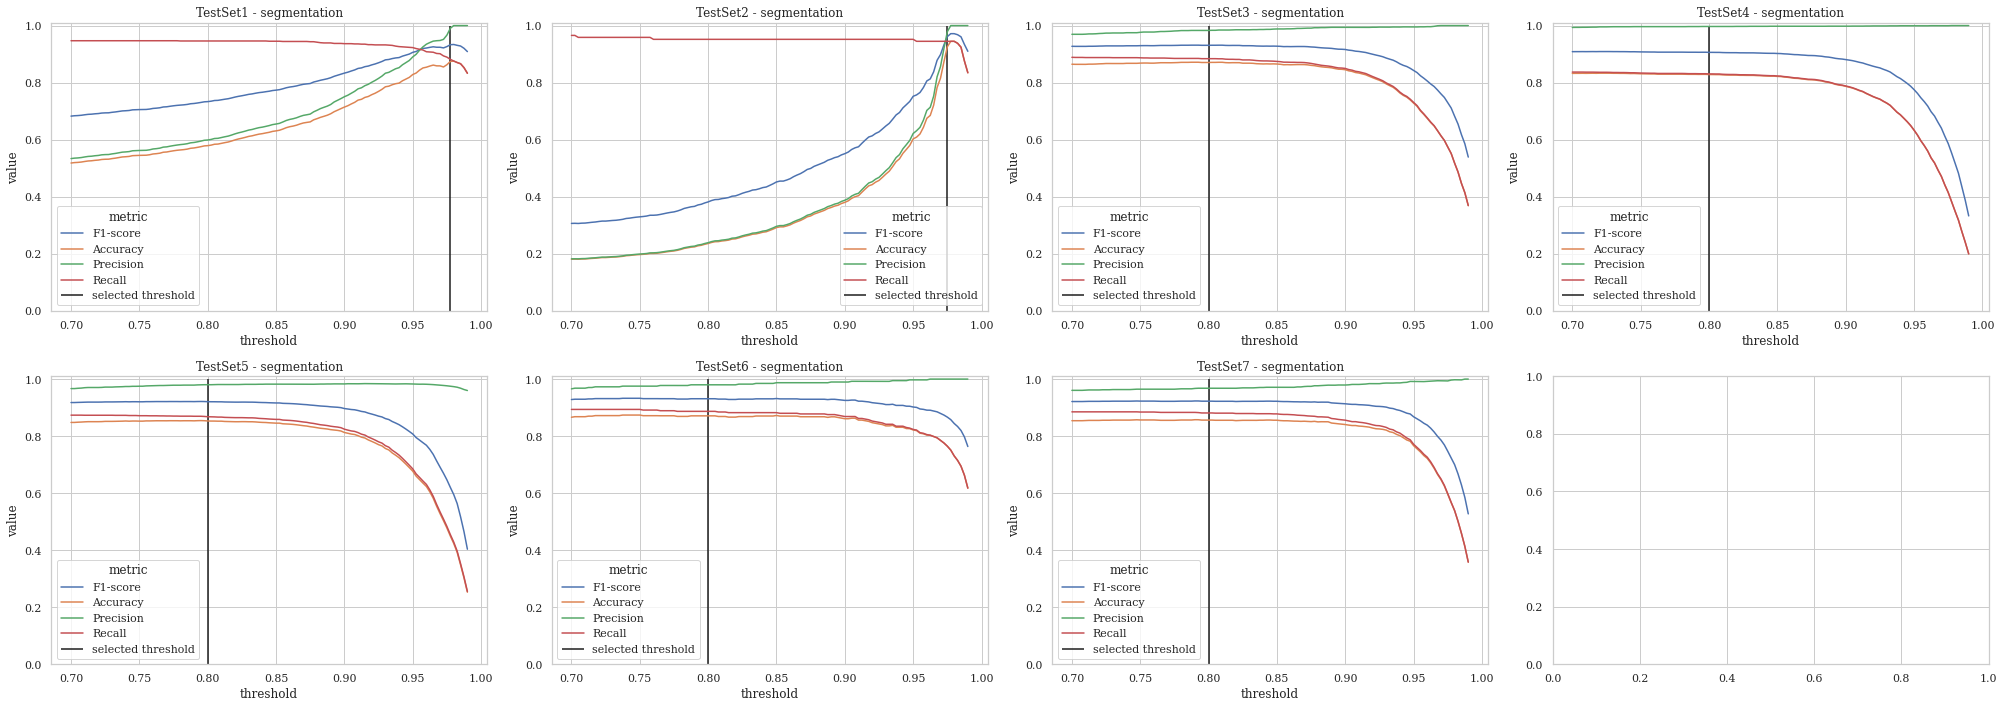

In [10]:
sns.set(font="Serif", font_scale=1, style="whitegrid")

n_plots = len(threshold_results.groupby(['test set', 'task']))
nrows = (n_plots + 3) // 4
fig, axes = plt.subplots(nrows, 4, figsize=(28, 5*nrows))
axes = iter(axes.ravel())

for (testset_name, task), sub_results in tqdm(
    threshold_results.groupby(['test set', 'task'])):
  axis = next(axes)
  
  optimal_threshold = optimal_thresholds[testset_name]
  axis.vlines(optimal_threshold, 0, 1, label='selected threshold')
  
  sns.lineplot(data=sub_results, x='threshold', y='value',
               hue='metric', ax=axis, ci=None)
  axis.set_title(f'{testset_name} - {task}'); axis.set_ylim(0, 1.01)
plt.tight_layout()

#### Export

Export as spreadsheet.

In [11]:
threshold_results.pivot(index=['threshold'],
                        columns=['test set', 'task', 'metric'],
                        values='value').to_excel('threshold-tuning-results.xlsx')

try:
  from google.colab.files import download
  download('threshold-tuning-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Exports for paper

In [12]:
sns.set(font="Serif", font_scale=1.5, style="whitegrid")

def crop(fn):
  im = imread(fn)
  is_white = (im[..., :3] == 255).min(2)
  y0, y1 = np.where(~is_white.min(1))[0][[0, -1]]
  x0, x1 = np.where(~is_white.min(0))[0][[0, -1]]
  imsave(fn, im[y0:y1+1, x0:x1+1])

if exports_for_paper:
  for testset_name, testset_results in tqdm(threshold_results[
    threshold_results['task'] == 'segmentation'
  ].groupby('test set')):
    fig, axis = plt.subplots(figsize=(10, 7), frameon=False)
    optimal_threshold = optimal_thresholds[testset_name]
    axis.vlines(optimal_threshold, 0, 1, label='selected threshold')
      
    sns.lineplot(data=testset_results, x='threshold', y='value', hue='metric', ax=axis, ci=None)
    axis.set_ylim(0, 1.01)
    axis.legend([],[], frameon=False)
    fn = f'Threshold-calibration-curve-segmentation-{testset_name}.png'
    fig.savefig(fn)
  
    crop(fn)
    !zip -qq paper-results.zip '{fn}'
    !rm '{fn}'
    plt.close()
  
  # create seperate legend
  fig, axis = plt.subplots(figsize=(7, 7))
  optimal_threshold = optimal_thresholds[testset_name]
  axis.vlines(optimal_threshold, 0, 1, label='selected threshold')
  sns.despine(bottom = True, left = True)
  sns.lineplot(data=testset_results, x='threshold', y='value', hue='metric',
               ax=axis, ci=None)
  axis.set_xlim(-2, -1); axis.set_xticks([]); axis.set_yticks([]);
  axis.set_xlabel(''); axis.set_ylabel('');
  axis.legend(bbox_to_anchor=(0.05, 1), loc=2, borderaxespad=0.,
              title='metric')
  fn = f'Threshold-calibration-curve-segmentation-legend.png'
  fig.savefig(fn)
  crop(fn)
  !zip -qq paper-results.zip '{fn}'
  !rm '{fn}'
  plt.close()

  !zip -qq paper-results.zip 'threshold-tuning-results.xlsx'

### Tuning `dmax` and `epsilon` hyperparameters for tracking

In [13]:
metrics = []

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(pipeline_path, testset_name)
  ground_truth = yit.get_ground_truth(pipeline_path, testset_name)
  
  # Mask R-CNN results
  threshold = optimal_thresholds[testset_name]
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=threshold, device='cuda:0')
  
  for dmax in tqdm(dmaxs, desc=f'Progress for {testset_name}', leave=False):
    # Distances only depend on dmax, and hence can be reused for all epsilons
    t0 = time.time()
    distances = tracking.get_distances(maskrcnn_detections, maskrcnn_masks,
                                       dmax=dmax, device='cuda:0')
    
    for epsilon in epsilons:
      # Tracking Mask R-CNN results via DBSCAN clustering
      t0 -= time.time()
      maskrcnn_detections = tracking.track_cells(
        maskrcnn_detections, maskrcnn_masks,
        dmax=dmax, min_samples=3, eps=epsilon, device='cuda:0',
        distances = distances)
      
      metrics.extend([
        {'test set': testset_name, 'task': task, 'model': 'Mask R-CNN',
         'threshold': threshold, 'dmax': dmax, 'eps': epsilon,
         'metric': metric, 'value': value}
        for task, get_metrics in {
            'tracking': evaluation.get_tracking_metrics,
            }.items()
        for metric, value in evaluation.calculate_metrics(get_metrics(
          ground_truth, maskrcnn_detections, maskrcnn_masks
        )).items()
      ])

tracking_results = pd.DataFrame(metrics)

#### Results

Several performance metrics represented by bars or a heatmap for different `eps` and `dmax` values.

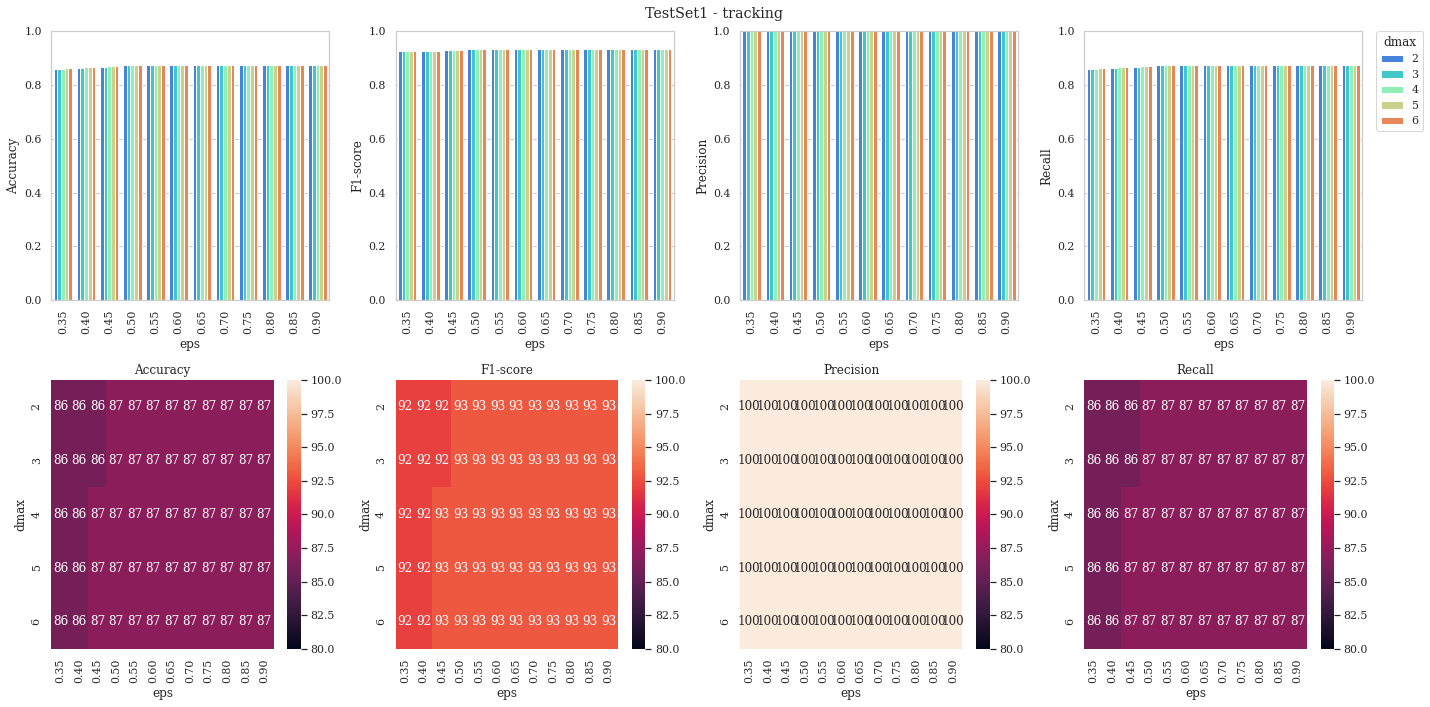

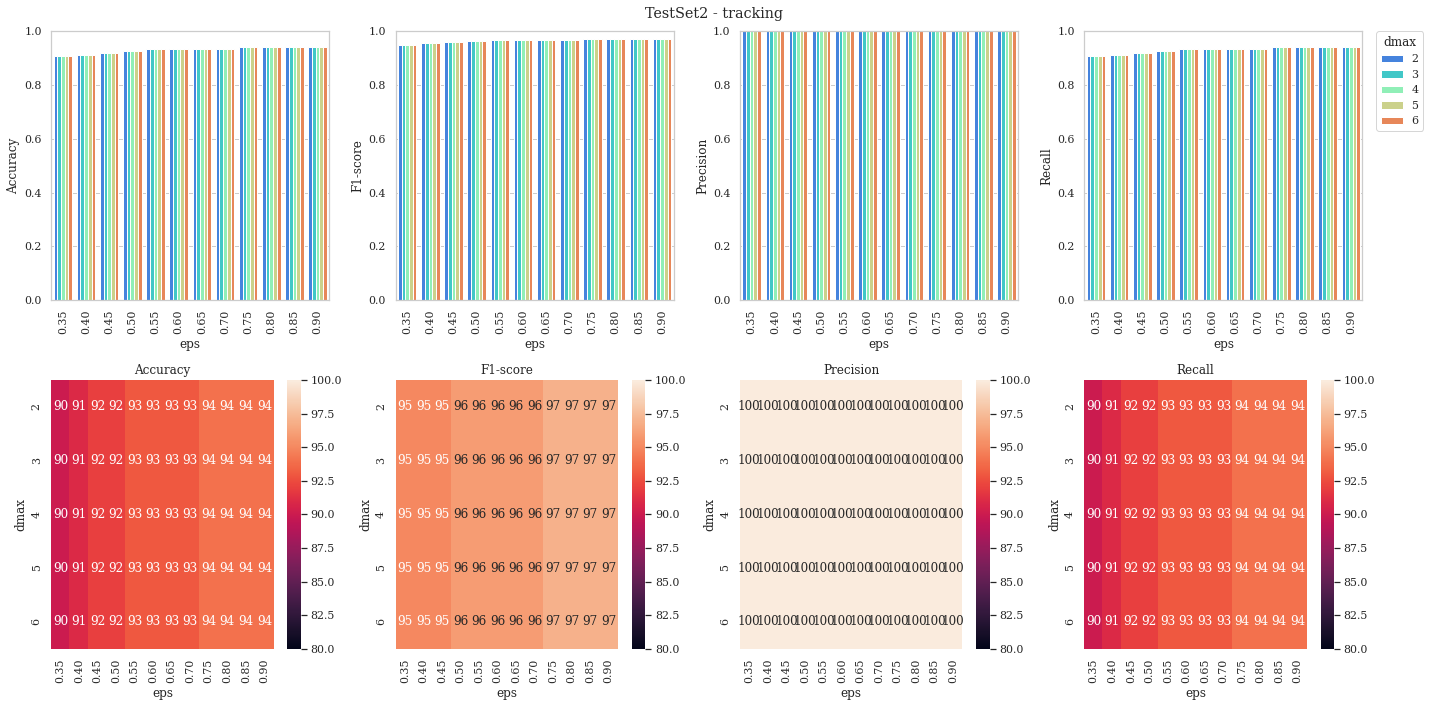

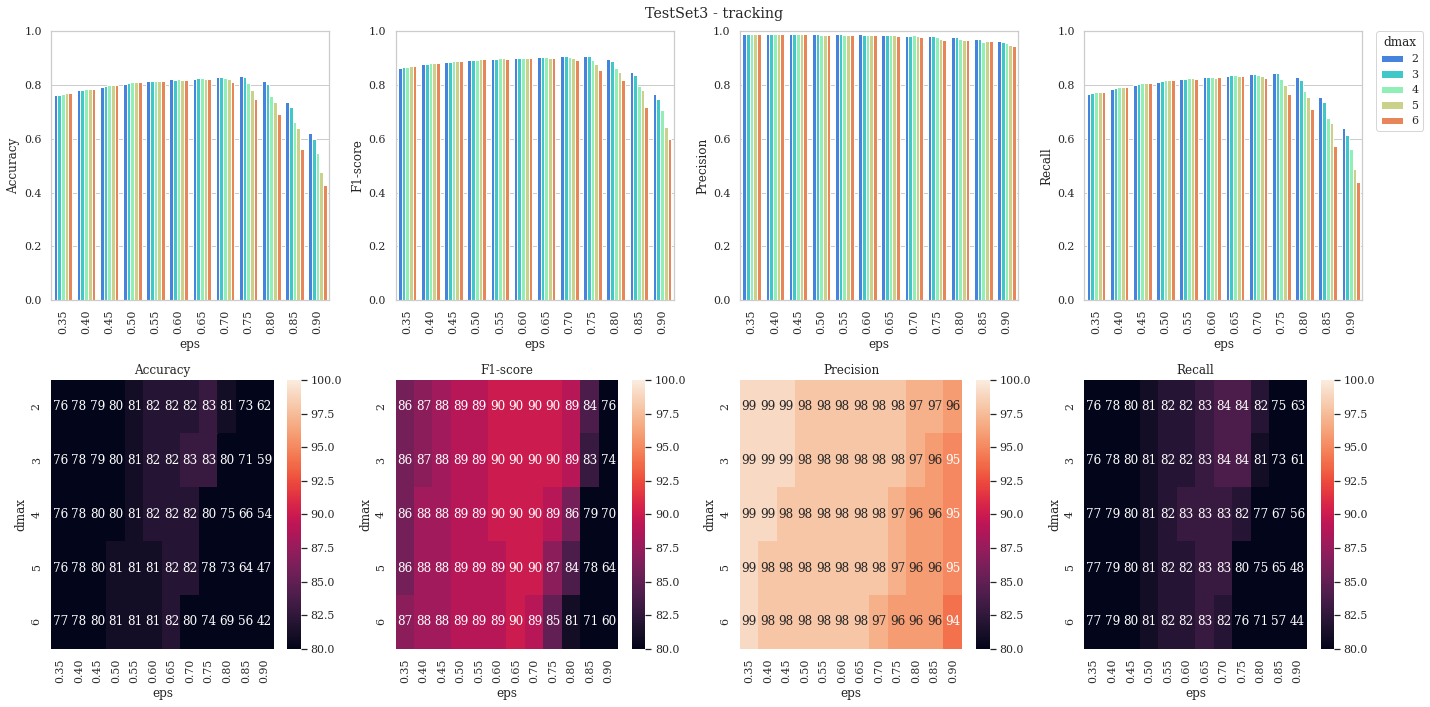

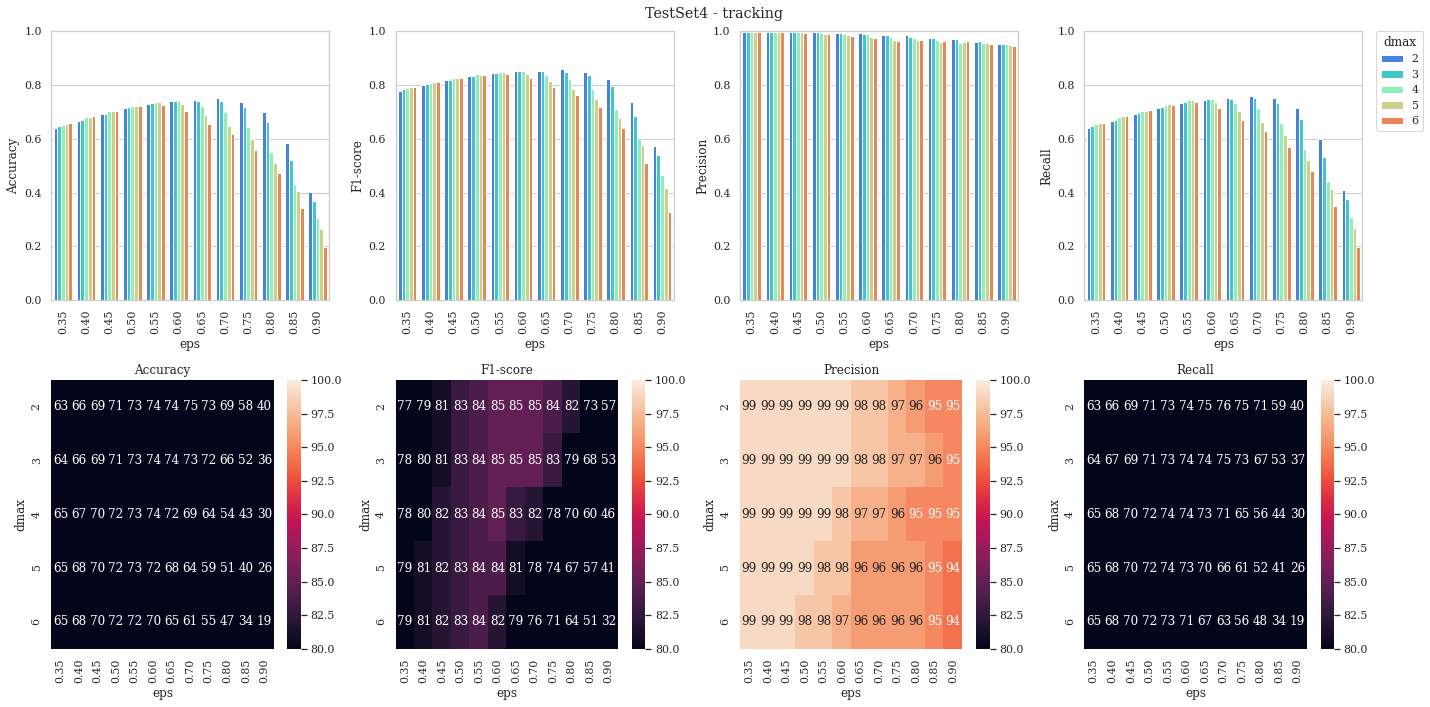

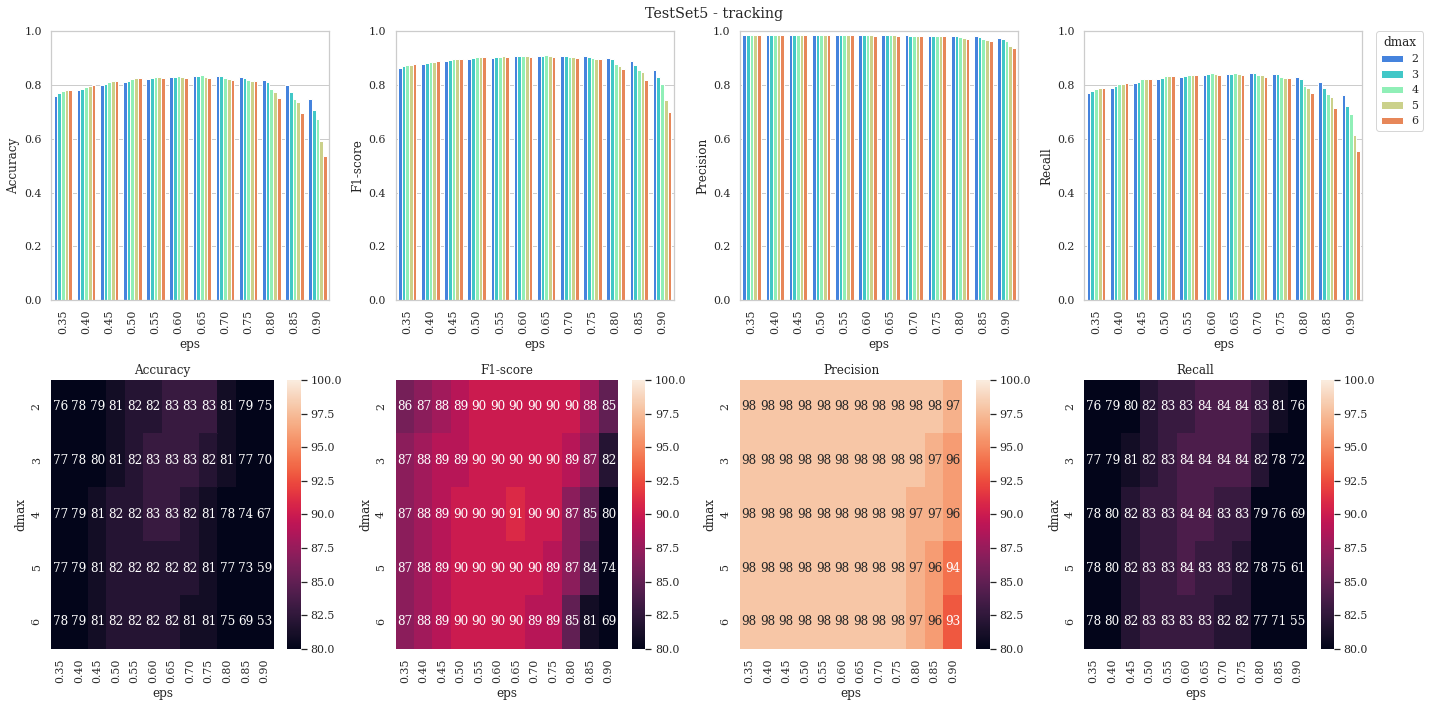

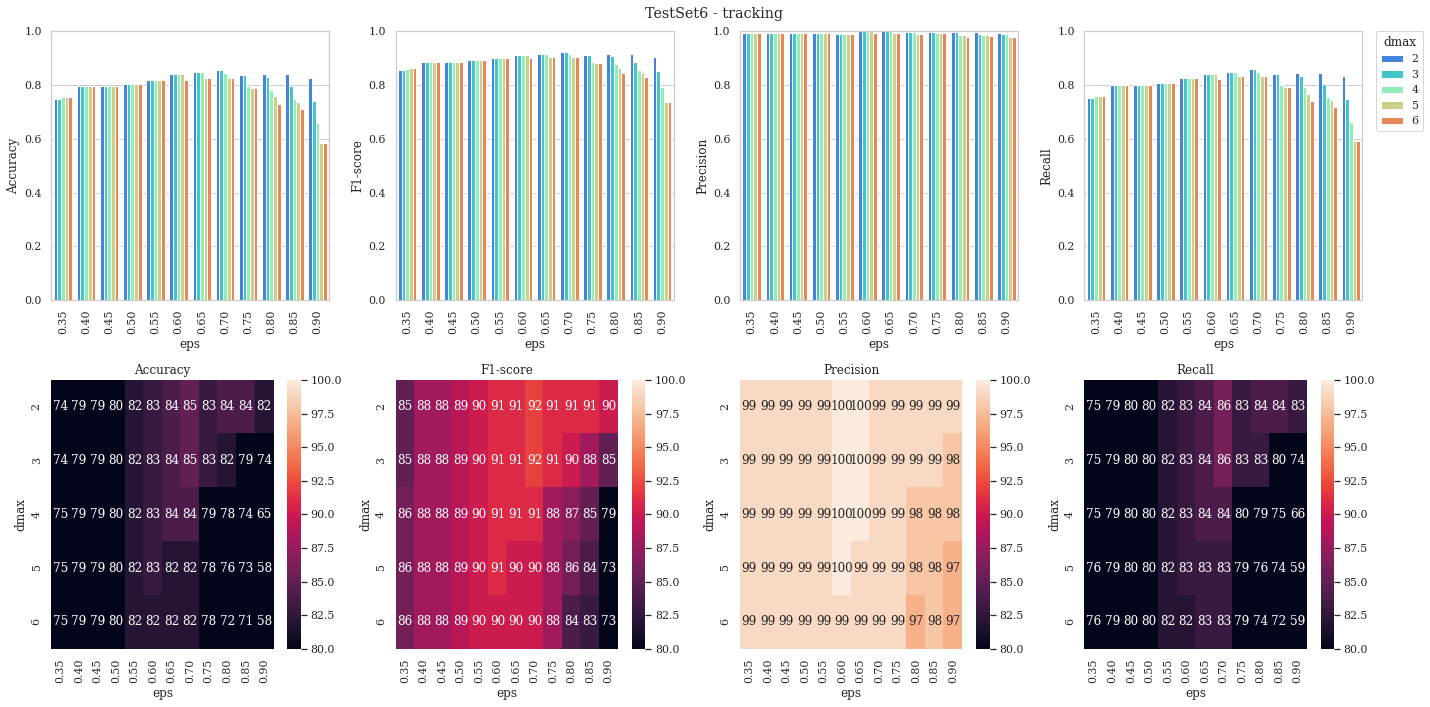

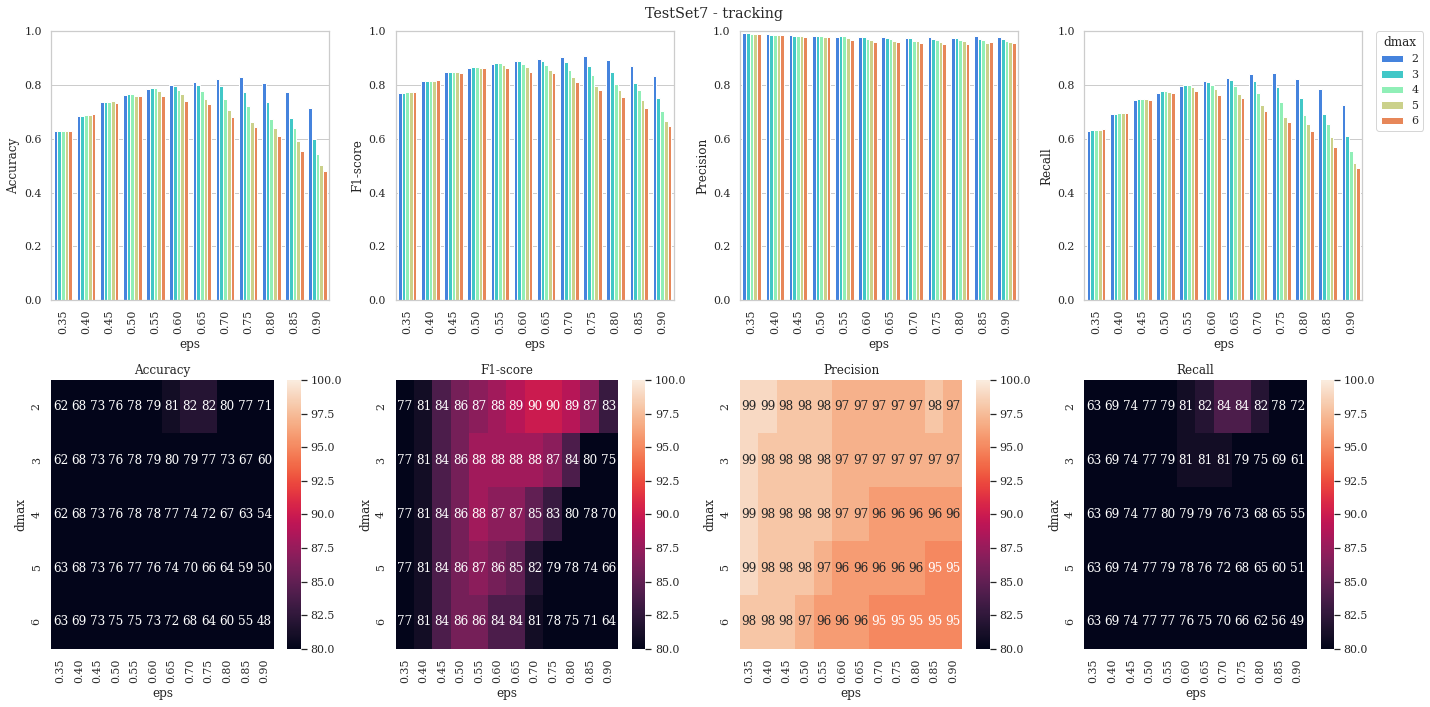

In [14]:
sns.set(font="Serif", font_scale=1, style="whitegrid")
for (testset_name, task), set_task_rows in tqdm(tracking_results.groupby(['test set', 'task'])):
  fig, axes = plt.subplots(2, 4, figsize=(20, 10))
  for (metric, rows), (ax0, ax1) in zip(set_task_rows.groupby('metric'), axes.T):
    rows = rows.rename({'value': metric}, axis=1)
    sns.barplot(data=rows.rename({'value': metric}, axis=1),
                hue='dmax', x='eps', y=metric, palette='rainbow', ax=ax0)
    ax0.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
    ax0.set_ylim(0, 1)
    if ax0 == axes[0,3]:
      ax0.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='dmax')
    else:
      ax0.legend([],[], frameon=False)

    # Show as pecentages
    rows = (100 * rows.pivot('dmax', columns=['eps'], values=metric)).astype(int)
    sns.heatmap(data=rows, annot=True, ax=ax1, vmin=80, vmax=100, fmt='d')
    ax1.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
    ax1.set_title(metric)
  plt.tight_layout(rect=(0, 0, 1, 0.97)) # allow some space for the main title
  fig.suptitle(f'{testset_name} - {task}')

#### Export

Save and download these results as a spreadsheets.

In [15]:
tracking_results.pivot(
  index=['test set', 'dmax', 'eps'],
  columns=['task', 'metric'], values='value').to_excel('tracking-tuning-results.xlsx')

try:
  from google.colab.files import download
  download('tracking-tuning-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Exports for paper

In [16]:
sns.set(font="Serif", font_scale=1.5, style="whitegrid")

def crop(fn):
  im = imread(fn)
  is_white = (im[..., :3] == 255).min(2)
  y0, y1 = np.where(~is_white.min(1))[0][[0, -1]]
  x0, x1 = np.where(~is_white.min(0))[0][[0, -1]]
  imsave(fn, im[y0:y1+1, x0:x1+1])

if exports_for_paper:
  for testset_name, set_task_rows in tqdm(tracking_results[
    tracking_results['task'].isin(['tracking'])
    # & tracking_results['test set'].isin(['TestSet1', 'TestSet3', 'TestSet5'])
  ].groupby('test set')):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    for (metric, rows), axis in zip(set_task_rows.groupby('metric'), axes.ravel()):
      rows = rows.rename({'value': metric}, axis=1)
      g = sns.barplot(data=rows, hue='dmax', x='eps', y=metric,
                      palette='rainbow', ax=axis)
      axis.set_ylim(int(rows[metric].min() * 5) / 5, 1)
      axis.set_xticks(np.arange(len(epsilons)))
      axis.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
      if axis == axes[0,1]:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                    title='$\Delta t_{max}$')
      else:
        axis.legend([],[], frameon=False)
    plt.tight_layout()
    
    fn = f'Tracking-calibration-curve-segmentation-{testset_name}.png'
    fig.savefig(fn)
    crop(fn)
    !zip -qq paper-results.zip '{fn}'
    !rm '{fn}'
    plt.close()
  !zip -qq paper-results.zip 'tracking-tuning-results.xlsx'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.


### Acountability of False Positives and Negatives

Illustrates whether segentation or tracking causes the tracking errors. Ideally, one would compare tracking performance on the segmetation output and the ground truth segmentation, to empirically establish the cause. However, the YIT ground truths do not contain segmentations, but rather coordinates, and hence can't be used as input for tracking.

The `get_tracking_metrics` does not just report false negatives, positives and true positives, but also the cause of these false negatives and positives.

Note that false negatives and true positives partition the following set of ground truths in adjacent frames with the same label:

$S_1 = \{(a, b) \vert a, b \in \textrm{ground truth}, a\neq b,\;frame(a)=frame(b)+1,\; label(a) = label(b)\}$

Where $label$ is the tracking label assigned by the ground truth. The false negatives are those for which

 * Mask-RCNN segmentation didn't detect either $a$ or $b$ (segmentation column), or else
 * Tracking marked either or both $a$ or $b$ as an outlier (untracked column), or else
 * Tracking did not assign the same label to $a$ and $b$ (poor tracking column)

A similar set over partitions the false positives and true positives of detections in adjacent frames with the same tracking label:

$S_2 = \{(a, b) \vert a, b \in \textrm{detections},\;a\neq b,\;frame(a)=frame(b)+1,\;\hat{label}(a) = \hat{label}(b)\}$

Where $\hat{label}$ is the tracking label assigned by the algorithm. In this case the false positives can be classified 
 * Either or both $a$ and $b$ were not in the ground truth (segmentation column), or else
 * The ground truth did not assign the same label to $a$ and $b$ (poor tracking column).

Due to this partitioning, the false positives and negatives can be accounted to either segmention errors, tracking ourliers or a tracking mistake.



In [17]:
metrics = []
import time

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(pipeline_path, testset_name)
  
  ground_truth = yit.get_ground_truth(pipeline_path, testset_name)
  
  # YeaZ results
  yeaz_masks, yeaz_detections = load_test_yeaz_detections(pipeline_path, testset_name)
  
  # Mask R-CNN results
  threshold = optimal_thresholds[testset_name]
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=threshold, device='cuda:0')
  
  # Tracking Mask R-CNN results via DBSCAN clustering
  maskrcnn_detections = tracking.track_cells(maskrcnn_detections, maskrcnn_masks,
                                             dmax=2, min_samples=3, eps=0.6, device='cuda:0')
  
  metrics.extend([
      {'test set': testset_name, 'task': task, 'model': model,
       'metric': metric, 'value': value}
      for task, get_metrics in {
          'tracking': evaluation.get_tracking_metrics,}.items()
      for model, detections, masks in [
        ('Mask R-CNN', maskrcnn_detections, maskrcnn_masks),
      ]
      for metric, value in get_metrics(
        ground_truth, detections, masks).items()
  ])

tracking_acounting_results = pd.DataFrame(metrics)

#### Results

In [18]:
tracking_results_table = tracking_acounting_results.pivot('test set', 'metric', 'value')

fn = 'false negatives'
fp = 'false positives'
tracking_acounting = pd.DataFrame({
    (fn, '#'): 0,
    (fn, 'segmentation'): 100 * tracking_results_table['segmentation fn'] /
                                tracking_results_table['fn'],
    (fn, 'untracked'):    100 * tracking_results_table['untracked fn'] /
                               tracking_results_table['fn'],
    (fn, 'poor tracking'): 0,
    (fp, '#'): 0,
    (fp, 'segmentation'): 100 * tracking_results_table['segmentation fp'] /
                                tracking_results_table['fp'],
    (fp, 'poor tracking'): 0,
          
}).round(3)

tracking_acounting[(fn, 'poor tracking')] = 100 - tracking_acounting[fn].sum(1)
tracking_acounting[(fp, 'poor tracking')] = 100 - tracking_acounting[fp].sum(1)
tracking_acounting.loc[tracking_results_table['fp'] == 0, fp] = np.nan
tracking_acounting.loc[tracking_results_table['fn'] == 0, fn] = np.nan
tracking_acounting[(fn, '#')] = tracking_results_table['fn']
tracking_acounting[(fp, '#')] = tracking_results_table['fp']

tracking_acounting = tracking_acounting.style.bar(
    subset = [x for x in tracking_acounting.columns if x[1] != '#'],
    align='mid', color=['#d65f5f', '#5fba7d'], vmin=0, vmax=100).format(
        lambda x: f'{x:3.1f} %' if x==x else 'n/a',
        subset = [x for x in tracking_acounting.columns if x[1] != '#']
    ).format(
        lambda x: '{:3d}'.format(int(x)) if x==x else 'n/a',
        subset = [x for x in tracking_acounting.columns if x[1] == '#']
    ).set_properties(**{'text-align': 'center'})
tracking_acounting

#### Export

In [19]:
tracking_acounting.to_excel('tracking-accounting-results.xlsx')

try:
  from google.colab.files import download
  download('tracking-accounting-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Exports for paper

In [20]:
if exports_for_paper:
  tracking_acounting.to_excel('tracking-performance-accounting.xlsx')
  !zip -qq paper-results.zip 'tracking-performance-accounting.xlsx'
  !rm 'tracking-performance-accounting.xlsx'

## Running time estimation

In [21]:
metrics = []

devices = ['cuda:0', 'cpu'] # remove CPU if you're in a hurry

repeats = 4 # or lower the repeats if you want CPU results but are also in a
            # hurry


for _, testset_name, device in tqdm(list(product(range(repeats),
                                                 testset_names, devices))):
  image = yit.get_test_movie(pipeline_path, testset_name)
  threshold = optimal_thresholds[testset_name]
  loading_time = -time.time()
  model = segmentation.get_model(model_filename, seg_thresh=threshold,
                                device=device)
  loading_time += time.time()

  segmentation_time = -time.time()
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(image,
                                                                      model)
  segmentation_time += time.time()

  tracking_time = - time.time()
  maskrcnn_detections = tracking.track_cells(
      maskrcnn_detections, maskrcnn_masks,
      dmax=2, min_samples=3, eps=0.6, device=device)
  tracking_time += time.time()
  
  metrics.extend([{
      'test set': testset_name, '# frames': image.shape[0],
      'height': image.shape[1], 'width': image.shape[2],
      '# detections': len(maskrcnn_detections), 'device': device,
      '# tracked cells': len(set(maskrcnn_detections['cell'].unique()) - {-1}),
      'task': task, 'running time': running_time,
    }
    for task, running_time in [
      ('loading segmentation model', loading_time),
      ('segmentation', segmentation_time),
      ('tracking', tracking_time),
    ]
  ])
  
running_time_results = pd.DataFrame(metrics)

### Results

In [22]:
meta_columns = ['# frames', 'height', 'width', '# detections', '# tracked cells']
assert running_time_results.groupby(by=['test set', 'task'])[meta_columns].std().min().min() == 0, (
    "meta columns should not vary for the same test")

running_time_results['device'] = running_time_results['device'].replace('cuda:0', 'gpu')

running_time_mean = running_time_results.groupby(by=['test set', 'task', 'device'] + meta_columns).mean()[['running time']]
running_time_std = running_time_results.groupby(by=['test set', 'task', 'device'] + meta_columns).std()[['running time']]

for _ in range(len(meta_columns) + 3):
  running_time_mean.reset_index(level=0, inplace=True)
  running_time_std.reset_index(level=0, inplace=True)


running_time_mean = running_time_mean.pivot(['test set']+meta_columns, columns=['task', 'device'], values=['running time'])
running_time_std = running_time_std.pivot(['test set']+meta_columns, columns=['task', 'device'], values=['running time'])

running_time_mean.applymap('{:1.2f} ± '.format) + running_time_std.applymap('{:1.2f} s'.format)

running time  ...               
task                                                        loading segmentation model  ...       tracking
device                                                                             cpu  ...            gpu
test set # frames height width # detections # tracked cells                             ...               
TestSet1 60       512    512   1038         22                           0.81 ± 0.02 s  ...  0.58 ± 0.01 s
TestSet2 30       512    512   140          7                            0.90 ± 0.19 s  ...  0.10 ± 0.00 s
TestSet3 20       512    512   2053         169                          0.80 ± 0.01 s  ...  1.55 ± 0.01 s
TestSet4 20       512    512   3474         300                          0.81 ± 0.00 s  ...  3.55 ± 0.01 s
TestSet5 20       512    512   2738         196                          0.81 ± 0.01 s  ...  2.46 ± 0.04 s
TestSet6 10       512    512   400          44                           0.81 ± 0.01 s  ...  0.22 ± 0.00 s
TestSet7 10       512    512   1403         157                          0.81 ± 0.01 s  ...  1.09 ± 0.02 s

[7 rows x 6 columns]

### Export


In [23]:
export = pd.merge(
    running_time_mean['running time'], running_time_std['running time'],
    left_index=True, right_index=True, suffixes=('  mean', '  stdev'),
)
export.columns =  pd.MultiIndex.from_tuples([(task, column[1], statistic) for column in export.columns
                                             for task, statistic in [column[0].split('  ')]])
export.columns.names = ['running time', 'device', 'statistic']
export = export[sorted(export.columns)]

export.to_excel('running-time-results.xlsx')

try:
  from google.colab.files import download
  download('running-time-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Exports for paper

In [24]:
if exports_for_paper:
  !zip -qq paper-results.zip 'running-time-results.xlsx'

## Download Exports for paper

In [25]:
if exports_for_paper:
  try:
    from google.colab.files import download
    download('paper-results.zip')
  except ImportError:
    print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>